## 🛠️ Hyperparameter Optimization for Base Models

In this notebook I would optimize the hyperparameters of the base models to get their best parameters for the dataset and use them for further prediction processes in the custom ensemble.

In [40]:
import pickle
import json
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import roc_curve, roc_auc_score, accuracy_score
from scipy.stats import randint, uniform
from sklearn.ensemble import RandomForestClassifier
from lightgbm import LGBMClassifier
from sklearn.model_selection import RandomizedSearchCV

In [2]:
# Loading the Datasets
train = pd.read_csv("../dataset/wine-train-balanced.csv")
test = pd.read_csv("../dataset/wine-test.csv")

# Create features and labels
X_train, y_train = train.drop(["quality"], axis=1), train["quality"]
X_test, y_test = test.drop(["quality"], axis=1), test["quality"]

In [3]:
# Define models
rf_clf = RandomForestClassifier(random_state=33)
lgbm_clf = LGBMClassifier(random_state=33)

### Optimizing Random Forest

I would perform a randomized search over key Random Forest parameters to find a balance between predictive power and computational efficiency.

**Parameters Tuned**

- **n_estimators**: Number of decision trees in the forest.  
  More trees generally improve performance but increase training time.

- **criterion**: Function used to measure the quality of a split.  
  *gini* minimizes misclassification probability, *entropy* uses information gain, and *log_loss* (cross-entropy) can improve probability calibration.

- **max_depth**: Maximum depth of each tree.  
  Controls model complexity—deeper trees capture more detail but risk overfitting.  
  I would explore depth values from 3 to 20 and also allow `None` for unlimited depth.

- **min_samples_split**: Minimum number of samples required to split an internal node.  
  Higher values make the model more conservative and can reduce overfitting.

- **min_samples_leaf**: Minimum number of samples required at a leaf node.  
  Ensures leaves represent enough data to generalize well.

- **max_features**: Number of features to consider when looking for the best split.  
  Options include the square root of total features (`"sqrt"`), the base-2 logarithm (`"log2"`), or all features (`None`).  
  This adds diversity to individual trees, improving ensemble performance.

**Search Strategy**

`RandomizedSearchCV` randomly samples combinations from these parameter ranges.  
I'm using RandomizedSearch because the parameter space is large and includes continuous ranges. GridSearch (exhaustive parameter sampling) would be more demanding computationally with little extra benefit.

In [4]:
# Parameters
rf_params = {
    "n_estimators": randint(50, 500),
    "criterion": ["gini", "entropy", "log_loss"],
    "max_depth": [None] + list(range(3, 21)),
    "min_samples_split": randint(2, 20),
    "min_samples_leaf": randint(1, 10),
    "max_features": ["sqrt", "log2", None]
}

rf_search = RandomizedSearchCV(
    estimator=rf_clf,
    param_distributions=rf_params,
    n_iter=70,
    scoring="roc_auc",
    cv=5,
    verbose=1,
    # n_jobs=-1,
    random_state=33
)

In [5]:
# Start RandomizedSearch
rf_search.fit(X_train, y_train)

Fitting 5 folds for each of 70 candidates, totalling 350 fits


,estimator,RandomForestC...ndom_state=33)
,param_distributions,"{'criterion': ['gini', 'entropy', ...], 'max_depth': [None, 3, ...], 'max_features': ['sqrt', 'log2', ...], 'min_samples_leaf': <scipy.stats....x7fa4c4bda710>, ...}"
,n_iter,70
,scoring,'roc_auc'
,n_jobs,None
,refit,True
,cv,5
,verbose,1
,pre_dispatch,'2*n_jobs'
,random_state,33
,error_score,nan


In [ ]:
print("Best Random Forest Parameters:", rf_search.best_estimator_.get_params())

# Save best model version
with open("../artifacts/rf_optimized.pkl", "wb") as file:
    pickle.dump(rf_search.best_estimator_, file)

# Save model hyperparameters
with open("../models/rf_optimized_params.json", "w") as file:
    json.dump(rf_search.best_estimator_.get_params(), file, indent=4)

Best Random Forest Parameters: {'bootstrap': True, 'ccp_alpha': 0.0, 'class_weight': None, 'criterion': 'log_loss', 'max_depth': 15, 'max_features': 'log2', 'max_leaf_nodes': None, 'max_samples': None, 'min_impurity_decrease': 0.0, 'min_samples_leaf': 2, 'min_samples_split': 4, 'min_weight_fraction_leaf': 0.0, 'monotonic_cst': None, 'n_estimators': 419, 'n_jobs': None, 'oob_score': False, 'random_state': 33, 'verbose': 0, 'warm_start': False}


In [ ]:
rf_opt = rf_search.best_estimator_

Test Accuracy: 0.8205


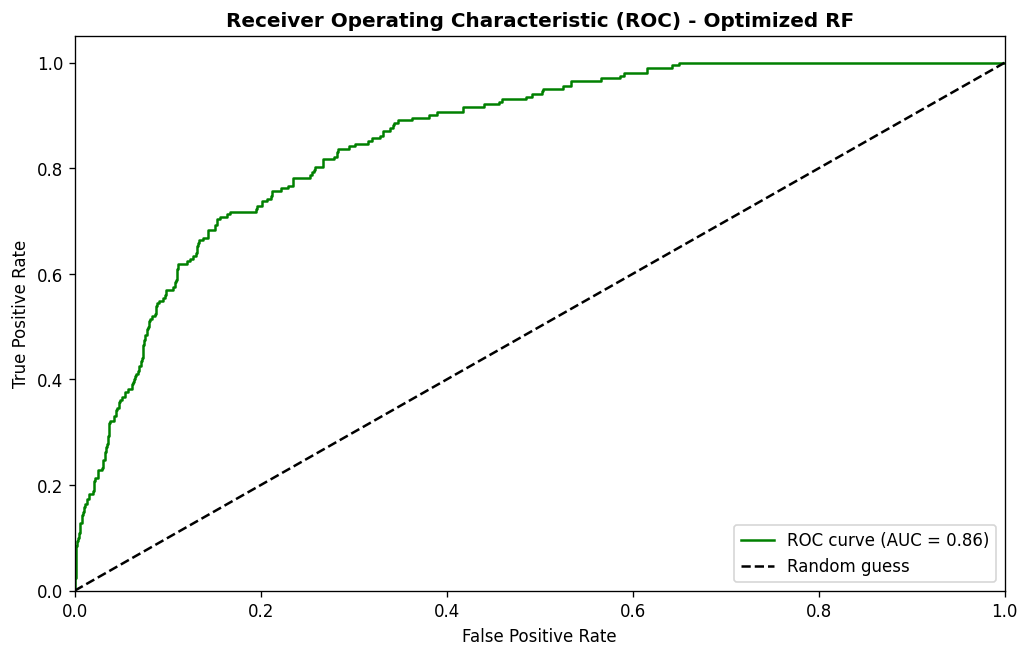

In [42]:
# Visualizing ROC-AUC for optimized Random Forest Model
# Array of predicted probabilities for the positive class
y_score_rf = rf_opt.predict_proba(X_test)[:, 1]

# Compute false positive rate, true positive rate, and thresholds
fpr, tpr, thresholds = roc_curve(y_test, y_score_rf)

# Compute the Area Under the Curve (AUC)
auc_score = roc_auc_score(y_test, y_score_rf)

print("Test Accuracy: {:.4f}".format(accuracy_score(y_test, rf_opt.predict(X_test))))

# Plot
plt.figure(figsize=(10, 6), dpi=120)
plt.plot(fpr, tpr, label=f"ROC curve (AUC = {auc_score:.2f})", color="green")
plt.plot([0, 1], [0, 1], 'k--', label='Random guess')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("Receiver Operating Characteristic (ROC) - Optimized RF", fontweight="bold")
plt.legend(loc="lower right")

plt.savefig("../img/rf_optimized_roc_auc.png")
plt.show()

### Optimizing LightGBM

**Parameters Tuned**

- **num_leaves**: Maximum number of leaves per tree.  
  More leaves let each tree model finer details and interactions but increase the risk of overfitting and memory use.

- **max_depth**: Maximum depth of individual trees.  
  Acts as a second control on model complexity. A value of `-1` (or `None`) allows unlimited depth, I also explore depths from 3 to 15 to keep trees interpretable.

- **learning_rate**: Step size shrinkage used in each boosting round.  
  Lower values slow learning and typically improve generalization, but require more boosting rounds.  
  I sample rates between 0.01 and 0.2.

- **n_estimators**: Number of boosting iterations (trees).  
  More estimators generally improve performance, especially with a smaller learning rate, at the cost of longer training time.

- **subsample**: Fraction of the training data randomly sampled for each tree.  
  Acts like bagging to reduce overfitting and improve robustness.  
  I search between 0.6 and 1.0.

- **colsample_bytree**: Fraction of features randomly selected for each tree.  
  Helps decorrelate trees and prevent overfitting.  
  I search between 0.6 and 1.0.

=> Search method and strategy is the same with RandomForest above.

In [34]:
lgbm_params = {
    'num_leaves': randint(20, 80),
    'max_depth': [-1] + list(range(3, 16)),
    'learning_rate': uniform(0.01, 0.2),
    'n_estimators': randint(50, 500),
    'subsample': uniform(0.6, 0.4),
    'colsample_bytree': uniform(0.6, 0.4)
}

lgbm_search = RandomizedSearchCV(
    estimator=lgbm_clf,
    param_distributions=lgbm_params,
    n_iter=80,
    scoring="roc_auc",
    cv=5,
    verbose=1,
    # n_jobs=-1,
    random_state=33
)

In [ ]:
lgbm_search.fit(X_train, y_train)

In [ ]:
print("Best LightGBM Parameters:", lgbm_search.best_estimator_.get_params())

# Save best model version
with open("../artifacts/lgbm_optimized.pkl", "wb") as file:
    pickle.dump(lgbm_search.best_estimator_, file)

# Save model hyperparameters
with open("../models/lgbm_optimized_params.json", "w") as file:
    json.dump(lgbm_search.best_estimator_.get_params(), file, indent=4)

Best LightGBM Parameters: {'boosting_type': 'gbdt', 'class_weight': None, 'colsample_bytree': np.float64(0.8041790107956245), 'importance_type': 'split', 'learning_rate': np.float64(0.16247492555874504), 'max_depth': 14, 'min_child_samples': 20, 'min_child_weight': 0.001, 'min_split_gain': 0.0, 'n_estimators': 448, 'n_jobs': None, 'num_leaves': 75, 'objective': None, 'random_state': 33, 'reg_alpha': 0.0, 'reg_lambda': 0.0, 'subsample': np.float64(0.9365271900465331), 'subsample_for_bin': 200000, 'subsample_freq': 0}


In [37]:
lgbm_opt = lgbm_search.best_estimator_

Test Accuracy: 0.8412


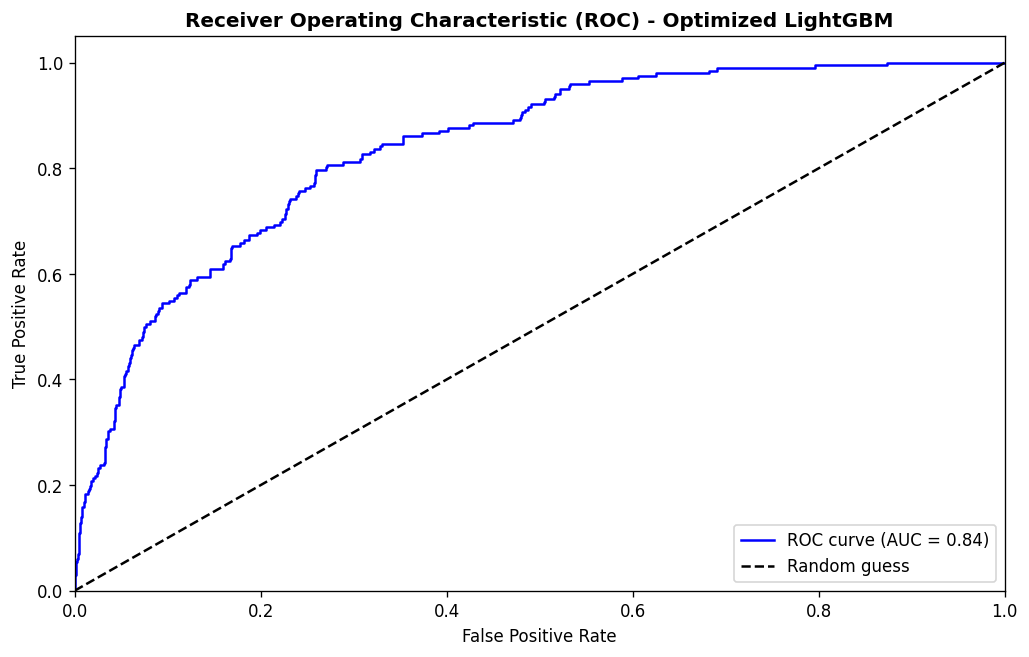

In [43]:
# Visualizing ROC-AUC for optimized Random Forest Model
# Array of predicted probabilities for the positive class
y_score_lgbm = lgbm_opt.predict_proba(X_test)[:, 1]

# Compute false positive rate, true positive rate, and thresholds
fpr, tpr, thresholds = roc_curve(y_test, y_score_lgbm)

# Compute the Area Under the Curve (AUC)
auc_score = roc_auc_score(y_test, y_score_lgbm)

print("Test Accuracy: {:.4f}".format(accuracy_score(y_test, lgbm_opt.predict(X_test))))

# Plot
plt.figure(figsize=(10, 6), dpi=120)
plt.plot(fpr, tpr, label=f"ROC curve (AUC = {auc_score:.2f})", color="blue")
plt.plot([0, 1], [0, 1], 'k--', label='Random guess')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("Receiver Operating Characteristic (ROC) - Optimized LightGBM", fontweight="bold")
plt.legend(loc="lower right")

plt.savefig("../img/lgbm_optimized_roc_auc.png")
plt.show()